In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
#create SparkSession instance
from pyspark import SparkConf
from pyspark.sql import SparkSession
spark = SparkSession.builder.config('spark.driver.memory', '16g').appName('CrediCardFraudDetection').getOrCreate()

23/01/21 15:26:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
import numpy as np

sc = spark.sparkContext

from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as func, Row
from pyspark import sql

from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, DoubleType, FloatType

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
train_df = spark.read.csv('fraudTrain.csv', header=True, inferSchema=True)
test_df = spark.read.csv('fraudTest.csv', header=True, inferSchema=True)

In [5]:
train_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [6]:
# Combine train and test data and use cross validation later 
combined_df = train_df.union(test_df)
row = combined_df.count()
col = len(combined_df.columns)
print(f'Dimension of the Dataframe is: {(row,col)}')

Dimension of the Dataframe is: (1852394, 23)


In [7]:
# generating column age, day_of_week, hour_of_transaction

from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, DoubleType

# Function to calculate the distance between two adress
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    newlon = lon2 - lon1
    newlat = lat2 - lat1
    haver_formula = (
        np.sin(newlat / 2.0) ** 2
        + np.cos(lat1) * np.cos(lat2) * np.sin(newlon / 2.0) ** 2
    )
    dist = 2 * np.arcsin(np.sqrt(haver_formula))
    miles = 3958 * dist
    return float(miles)
    
# create a udf for implementing python function in pyspark
udf_haversine = udf(haversine, DoubleType())

def create_column(data):
    
    # day of week and the transaction hour
    data = data.withColumn('day_of_week', date_format('trans_date_trans_time', 'EEEE')) #1st col added
    data = data.withColumn('hour_of_transaction', hour('trans_date_trans_time')) #2nd col added
    
    #month_year
    data = data.withColumn('year', year('trans_date_trans_time'))
    data = data.withColumn('month', month('trans_date_trans_time'))
    data = data.withColumn('month_year', concat_ws('-', data.year ,data.month)).drop(*['year', 'month']) #3rd col added
    
    # trans_date
    data = data.withColumn("trans_date", func.to_date(func.col("trans_date_trans_time")))
    
    #age
    #data = data.withColumn("age",round(months_between(current_date(),col("dob"))/lit(12),2))
    data = data.withColumn("age",round(months_between(col('trans_date'),col("dob"))/lit(12),2))
    data = data.withColumn("age", data["age"].cast(IntegerType()))
    
    # distance between merchant and client
    # data = data.withColumn("distance", udf_haversine("long", "lat", "merch_long","merch_lat"))
    
    return data
    
combined_df = create_column(combined_df)
train_df = create_column(train_df)
test_df = create_column(test_df)

In [8]:
# finding distance between merchant and customer

udf_haversine = udf(haversine, DoubleType())
combined_df = combined_df.withColumn("distance", udf_haversine("long", "lat", "merch_long","merch_lat"))

In [9]:
combined_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- hour_of_transaction: integer (nullable = true)
 |-- month_ye

In [10]:
# count unique credit cards
from pyspark.sql.functions import countDistinct
combined_df.select(countDistinct('cc_num').alias('CreditCard_Count')).show()

+----------------+
|CreditCard_Count|
+----------------+
|             999|
+----------------+



In [11]:
# Adding dervided columns to understand the credit card usage behaviour Dayly, Monthly and weekly.
combined_df.createOrReplaceTempView("combined_df")

new_df = \
    spark.sql(
    """SELECT *, mean(amt) OVER (
        PARTITION BY cc_num
        ORDER BY CAST(trans_date AS timestamp) 
        RANGE BETWEEN INTERVAL 0 DAYS PRECEDING AND CURRENT ROW
     ) AS rolling_24h_avg_amt, 
     
     mean(amt) OVER (
        PARTITION BY cc_num
        ORDER BY CAST(trans_date AS timestamp) 
        RANGE BETWEEN INTERVAL 6 DAYS PRECEDING AND CURRENT ROW
     ) AS rolling_1_week_avg_amt,
     
     mean(amt) OVER (
        PARTITION BY cc_num
        ORDER BY CAST(trans_date AS timestamp) 
        RANGE BETWEEN INTERVAL 29 DAYS PRECEDING AND CURRENT ROW
     ) AS rolling_1month_avg_amt,
     
     count(_c0) OVER (
    PARTITION BY cc_num, trans_date
    ) AS number_trans_24h,
    
    count(_c0) OVER (
    PARTITION BY cc_num, day_of_week
    ) AS number_trans_specific_day,
    
    count(_c0) OVER (
    PARTITION BY cc_num, month_year
    ) AS number_trans_month,
    
    sum(amt) OVER (
        PARTITION BY cc_num
        ORDER BY CAST(trans_date AS timestamp) 
        RANGE BETWEEN INTERVAL 89 DAYS PRECEDING AND CURRENT ROW
     ) AS total_3month_amt
     
     FROM combined_df""")

new_df = new_df.withColumn('weekly_avg_amt_over_3_months',(col('total_3month_amt')/ (1.0*12)))
new_df = new_df.drop(*['total_3month_amt'])

23/01/21 15:26:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [12]:
# changing the transdate_trans_time and dob to timestamp

new_df = new_df.withColumn('trans_date_trans_time_new', to_timestamp('trans_date_trans_time'))
new_df = new_df.drop('trans_date_trans_time')
new_df = new_df.withColumnRenamed('trans_date_trans_time_new','trans_date_trans_time')
new_df = new_df.withColumn('dob_new', to_date('dob'))
new_df = new_df.drop('dob')
new_df = new_df.withColumnRenamed('dob_new','dob')
new_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- hour_of_transaction: integer (nullable = true)
 |-- month_year: string (nullable = false)
 |-- trans_date: date (nullable = true)
 |-- age: integer 

In [13]:
np.round(new_df.select('age').toPandas().describe())

,age
count,1852394.0
mean,46.0
std,17.0
min,13.0
25%,32.0
50%,44.0
75%,57.0
max,96.0


In [14]:
new_df.select('age').describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|           1852394|
|   mean|45.767610994205334|
| stddev|17.412444644401624|
|    min|                13|
|    max|                96|
+-------+------------------+



In [15]:
def udf_age_category(age):
    if (age < 25):
        return 'Age Under 25'
    elif (age >= 25 and age < 40):
        return 'Age Between 25 & 40'
    elif (age >= 40 and age < 50):
        return 'Age Between 40 & 50'
    elif (age >=50 and age < 65):
        return 'Age between 50 & 65'
    elif (age >=65):
        return 'Age Over 65'
    else: return 'N/A'

age_udf = udf(udf_age_category)

new_df = new_df.withColumn('age_udf_cat',age_udf('age'))



In [16]:
age_distribution = new_df.select('age_udf_cat').groupBy('age_udf_cat').agg(count(col('age_udf_cat')).alias('Age_Count')).sort('Age_Count', ascending = False).show(truncate = False)
age_distribution

+-------------------+---------+
|age_udf_cat        |Age_Count|
+-------------------+---------+
|Age Between 25 & 40|588955   |
|Age Between 40 & 50|433516   |
|Age between 50 & 65|377176   |
|Age Over 65        |284802   |
|Age Under 25       |167945   |
+-------------------+---------+



<AxesSubplot: xlabel='age_udf_cat'>

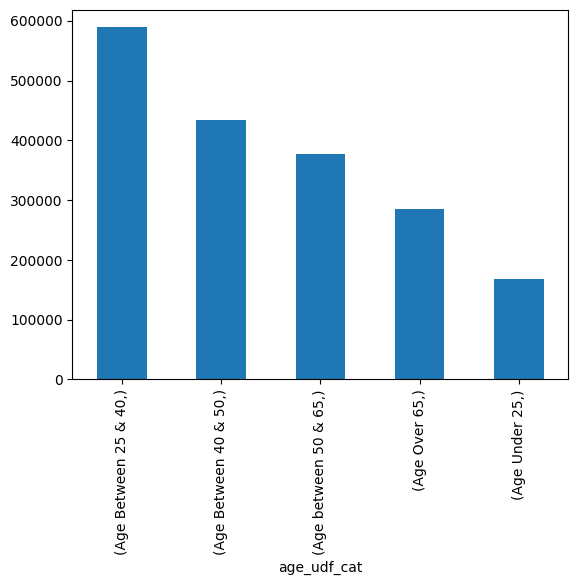

In [17]:
new_df.select('age_udf_cat').toPandas().value_counts().plot.bar()

In [18]:
# used pandas to get visualizations and tables based on monthly transactions and fraud transactions. 
df = new_df.select(to_date('month_year').alias('month_year'),col('trans_num').alias('number_of_transactions'),
                                col('cc_num').alias('number_of_customers'),col('is_fraud'),col('gender'),
                                   col('category')).toPandas()
df_ts_month_trans = df.groupby(df['month_year'])[['number_of_transactions','number_of_customers']].nunique().reset_index()
#df_ts_month_trans = df_ts_month_trans.sort_values(by = ['month_year'])
df_ts_month_trans

,month_year,number_of_transactions,number_of_customers
0,2019-01-01,52525,913
1,2019-02-01,49866,918
2,2019-03-01,70939,916
3,2019-04-01,68078,913
4,2019-05-01,72532,910
5,2019-06-01,86064,908
6,2019-07-01,86596,910
7,2019-08-01,87359,911
8,2019-09-01,70652,913
9,2019-10-01,68758,912


In [19]:
cols = ['_c0', 'age', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'street', 'city', \
        'zip', 'job', 'dob', 'state','unix_time', 'trans_num','lat', 'long','month_year', 'trans_date', 'merch_lat', 'merch_long']
preprocessed_data = new_df.drop(*cols)

In [20]:
# checking correlation between numerical features

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

numeric_features = [t[0] for t in preprocessed_data.dtypes if t[1] != 'string']
numeric_features_df = preprocessed_data.select(numeric_features)

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numeric_features_df.columns, outputCol=vector_col)
df_vector = assembler.transform(numeric_features_df).select(vector_col)

# Generating Correlation Matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

23/01/21 15:27:59 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, amt, lat, long, city_pop, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, amt, lat, long, city_pop, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTrain.csv
23/01/21 15:28:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, amt, lat, long, city_pop, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, amt, lat, long, city_pop, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTest.csv
23/01/21 15:28:46 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/01/21 15:28:46 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [21]:
# Count of fraud transactions and non-fraud transactions3
preprocessed_data.groupBy('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   9651|
|       0|1842743|
+--------+-------+



In [22]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

def transformColumnsToNumeric(df, inputCol):
    
    #apply StringIndexer to inputCol
    inputCol_indexer = StringIndexer(inputCol = inputCol, outputCol = inputCol + "-index").fit(df)
    df = inputCol_indexer.transform(df)
    
    onehotencoder_vector = OneHotEncoder(inputCol = inputCol + "-index", outputCol = inputCol + "-vector")
    df = onehotencoder_vector.fit(df).transform(df)
    
    return df
    
    pass

In [23]:
df = transformColumnsToNumeric(preprocessed_data, "category")
df = transformColumnsToNumeric(df, "gender")
df = transformColumnsToNumeric(df, "age_udf_cat")
df = transformColumnsToNumeric(df, "day_of_week")

In [24]:
from pyspark.ml.feature import VectorAssembler

cols = [
 'amt',
 'city_pop',
 'hour_of_transaction',
 'distance',
 'rolling_24h_avg_amt',
 'rolling_1_week_avg_amt',
 'rolling_1month_avg_amt',
 'number_trans_24h',
 'number_trans_specific_day',
 'number_trans_month',
 'weekly_avg_amt_over_3_months',
 'category-vector',
 'gender-vector',
 'age_udf_cat-vector',   
 'day_of_week-vector']

vectorAssembler = VectorAssembler().setInputCols(cols).setOutputCol('finalfeatures')
df = vectorAssembler.transform(df)

In [25]:
# creating train test set
train, validate, test = df.randomSplit([0.6, 0.3, 0.1])

In [26]:
train.groupBy('is_fraud').count().show()

23/01/21 15:29:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTrain.csv
23/01/21 15:29:42 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTest.csv


+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   5879|
|       0|1106353|
+--------+-------+



In [27]:
validate.groupBy('is_fraud').count().show()

23/01/21 15:30:22 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTrain.csv
23/01/21 15:30:36 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTest.csv


+--------+------+
|is_fraud| count|
+--------+------+
|       1|  2807|
|       0|552813|
+--------+------+



In [28]:
test.groupBy('is_fraud').count().show()

23/01/21 15:31:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTrain.csv
23/01/21 15:31:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTest.csv


+--------+------+
|is_fraud| count|
+--------+------+
|       1|   965|
|       0|183577|
+--------+------+



In [29]:
from pyspark.ml import feature, classification

# Default parameters
rf_model = classification.RandomForestClassifier(featuresCol='finalfeatures', labelCol='is_fraud').\
    fit(train)


23/01/21 15:32:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTrain.csv
23/01/21 15:32:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTest.csv
23/01/21 15:32:52 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, cat

In [30]:
feature_importance = pd.DataFrame(list(zip(cols, rf_model.featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending=False)
feature_importance

,feature,importance
4,rolling_24h_avg_amt,0.443206
5,rolling_1_week_avg_amt,0.160269
0,amt,0.114316
2,hour_of_transaction,0.075472
7,number_trans_24h,0.061939
6,rolling_1month_avg_amt,0.055397
8,number_trans_specific_day,0.020969
12,gender-vector,0.013872
9,number_trans_month,0.012226
10,weekly_avg_amt_over_3_months,0.006194


In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
bce = BinaryClassificationEvaluator(labelCol = 'is_fraud', metricName = 'areaUnderPR')

# Finding out area under PR curve for validation dataset
bce.evaluate(rf_model.transform(validate))

23/01/21 15:35:08 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTrain.csv
23/01/21 15:35:22 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTest.csv


0.8168371116561737

In [32]:
#Estimating Generalized Performance
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

predictions_rf = rf_model.transform(test)

#select only prediction and label columns
preds_and_labels_rf = predictions_rf.select(['prediction','is_fraud']).withColumn('is_fraud', func.col('is_fraud').cast(FloatType())).orderBy('prediction')

In [33]:
#Find Confusion Matrix
confusion_matrix_rf = MulticlassMetrics(preds_and_labels_rf.rdd.map(tuple)).confusionMatrix().toArray()
confusion_matrix_rf

23/01/21 15:36:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTrain.csv
23/01/21 15:36:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTest.csv


array([[1.83569e+05, 8.00000e+00],
       [5.04000e+02, 4.61000e+02]])

In [34]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
#Precision, Recall and F1 Score
precision_rf = confusion_matrix_rf[1,1]/np.add(confusion_matrix_rf[0,1], confusion_matrix_rf[1,1])
print("Precision: ",precision_rf)
recall_rf = confusion_matrix_rf[1,1]/np.add(confusion_matrix_rf[1,0], confusion_matrix_rf[1,1])
print("recall: ",recall_rf)
f1_score_rf = 2*(precision_rf*recall_rf)/(precision_rf+recall_rf)
print("f1_score: ",f1_score_rf)

Precision:  0.9829424307036247
recall:  0.47772020725388603
f1_score:  0.6429567642956765


In [36]:
#ROC and Precision-Recall Curve
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Let's use the run-of-the-mill evaluator
evaluator = BinaryClassificationEvaluator(labelCol='is_fraud')

# We have only two choices: area under ROC and PR curves :-(
auroc_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})
auprc_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderPR"})
print("Area under ROC Curve: {:.4f}".format(auroc_rf))
print("Area under PR Curve: {:.4f}".format(auprc_rf))

23/01/21 15:37:23 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTrain.csv
23/01/21 15:37:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTest.csv
23/01/21 15:38:17 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, cat

Area under ROC Curve: 0.9934
Area under PR Curve: 0.8232


23/01/21 15:43:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTrain.csv
23/01/21 15:43:14 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
 Schema: _c0, trans_date_trans_time, cc_num, category, amt, gender, lat, long, city_pop, dob, merch_lat, merch_long, is_fraud
Expected: _c0 but found: 
CSV file: file:///home/amits/environments/ModuleWisenotebooks/fraudTest.csv


Area under ROC Curve: 0.9934
Area under PR Curve: 0.8232


<AxesSubplot: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

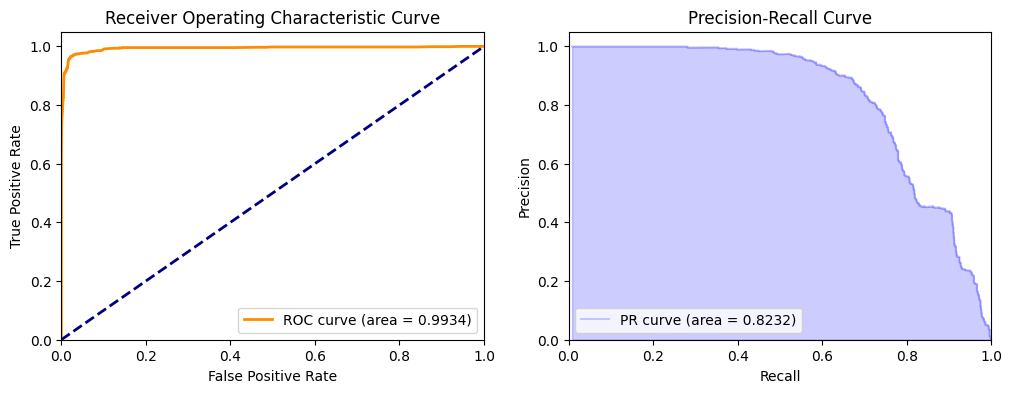

In [39]:
from handyspark import *
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(predictions_rf, scoreCol='probability', labelCol='is_fraud')

# We still can get the same metrics as the evaluator...
print("Area under ROC Curve: {:.4f}".format(bcm.areaUnderROC))
print("Area under PR Curve: {:.4f}".format(bcm.areaUnderPR))

# But now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])

In [40]:
spark.stop()